## Import Libraries

In [19]:
from collections import OrderedDict
from random import random

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline

from simulated_annealing import *

## Helper Functions

In [20]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

## Read Data

In [21]:
raw_df = pd.read_csv('machine_failure_cleaned.csv')

In [22]:
raw_df.shape

(9815, 8)

In [23]:
display_all(raw_df.head())

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine_failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0


In [24]:
display_all(raw_df.tail())

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine_failure
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0
9814,1500,40.2,30,0,0,0,0,0


In [25]:
raw_df['Machine_failure'].value_counts()

Machine_failure
0    9529
1     286
Name: count, dtype: int64

Highly Imbalance dataset, hence setting hyperparameter plays important role to get desired accuracy of model

In [26]:
raw_df.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in raw_df.columns]

## Split Dataset

We will split the data into train-test-validation sets with a 60:20:20 ratio.

In [27]:
x_tr, test = train_test_split(raw_df, test_size=0.2, shuffle=True)

In [28]:
train, valid = train_test_split(x_tr, test_size=0.25, shuffle=True)

In [29]:
xtrain, ytrain = train.drop('Machine_failure', axis=1), train['Machine_failure']
xvalid, yvalid = valid.drop('Machine_failure', axis=1), valid['Machine_failure']
xtest, ytest = test.drop('Machine_failure', axis=1), test['Machine_failure']

## Define Parameter Space (User Inputs - Modify code in this section)

The simulated annealing functions defined take in two dictionaries of parameters:

- Static parameters that are kept unchanged through out the tuning process - For the 
- Parameters to be tuned

Parameter search space is chosen based on the following articles:
- [XGBoost Notes on Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

Brief overview of the parameters:

- eval_metric - Metric to be used to measure model performance
- min_child_weight - The minimum sum of weights of all observations required in a child
- seed - random number seed to generate reproducible results
- max_depth - Maximum tree depth the individual learners can grow upto
- subsample - Fraction of observations used to train individual learners
- colsample_bytree - Fraction of columns considered for each split
- learning_rate - shrinkage weights of the weights
- gamma - Minimum loss reduction required to make a split
- scale_pos_weight - controls balance of positive and negative ratio
- silent - Parameter to that controls whether the model prints messages while running
- objective - Objective function used for learning
- n_estimators - Number of boosting rounds
- n_jobs - Number of parallel threds to run

In [30]:
# Parameters that are kept constant during the tuning process
const_param = {
    'silent': 0,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'n_estimators': 20,
    'n_jobs': -1
}

In [31]:
# Parameter search space
param_dict = OrderedDict()
param_dict['max_depth'] = [5, 10, 15, 20, 25]
param_dict['subsample'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['colsample_bytree'] = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_dict['learning_rate'] = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40]
param_dict['gamma'] = [0.00, 0.05, 0.10, 0.15, 0.20]
param_dict['scale_pos_weight'] = [30, 40, 50, 300, 400, 500, 600, 700]

Next up, let us define a function that takes in parameter dictionaries, train/validation datasets and an evaluation metric and returns the model and metric computed on the validation set. This function is iteratively called in the annealing process.

In [32]:
# Function to train model
def train_model(curr_params, param, Xtrain, Xvalid, Ytrain, Yvalid, metric=f1_score):
    """
    Train the model with given set of hyperparameters
    curr_params - Dict of hyperparameters and chosen values
    param - Dict of hyperparameters that are kept constant
    Xtrain - Train Data
    Xvalid - Validation Data
    Ytrain - Train labels
    Yvalid - Validaion labels
    metric - Metric to compute model performance on
    """
    params_copy = param.copy()
    params_copy.update(curr_params)
    model = XGBClassifier(**params_copy)
    model.fit(Xtrain, Ytrain)
    preds = model.predict(Xvalid)
    metric_val = metric(Yvalid, preds)
    
    return model, metric_val

Function choose_next choses set of parameters from the vicinity of current parameters. Randomly select one parameter to update and choose either previous or next value from the search space for that parameter. If the current parameter happens to be first or last value in the list, second or second to last values will be chosen respectively.

Simulated annealing function. Takes in parameter dictionaries, datasets, training function and annealing parameters. Steps involved in simulated annealing process are:

1. Initialize/Update parameters
2. Repeat step 1 if the updated parameters have already been used (use a hash function)
3. Fit a model and compute metric
4. If the metric value is an improvement over previous value, accept the parameters and go to step 1
5. If the metric value is not an improvement from previous value, accept the parameters with probability defined by annealing function ($e^{-\beta\Delta f/ T}$). In case the parameters are rejected, use parameters from previous iteration to create parameters for next iteration.

Annealing Function $e^{-\beta\Delta f/ T}$
- beta - constant term to normalize the values inside the exponential function
- T - Temperature, reduced after at a rate $\alpha$ for each fixed number of iterations
- $\Delta f$ - previous metric value - current metric value

Parameters $\alpha$, $\beta$ and T are chosen such that the probability of accepting a decrease in score is high initially but decreases with iterations. This will allow for a wider search space for the first few iterations and restrict the updates in later iterations.

In [33]:
res, best_model = simulate_annealing(param_dict, const_param, xtrain, xvalid, ytrain, yvalid, train_model, maxiters=100)

Starting Iteration 0
Local Improvement in metric from  -1.0000 to   0.5474  - parameters accepted
Global improvement in metric from  -1.0000 to   0.5474  - best parameters updated
Starting Iteration 1
No Improvement but parameters accepted. Metric change:  -0.3451 threshold: 0.2673 random number: 0.0984
Starting Iteration 2
Local Improvement in metric from   0.2023 to   0.5102  - parameters accepted
Starting Iteration 3
No Improvement and parameters rejected. Metric change:  -0.4576 threshold: 0.1738 random number: 0.7119
Starting Iteration 4
Local Improvement in metric from   0.5102 to   0.9273  - parameters accepted
Global improvement in metric from   0.5474 to   0.9273  - best parameters updated
Starting Iteration 5
No Improvement but parameters accepted. Metric change:  -0.1084 threshold: 0.6608 random number: 0.1523
Starting Iteration 6
No Improvement and parameters rejected. Metric change:  -0.1729 threshold: 0.4594 random number: 0.4725
Starting Iteration 7


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:17] WARNING: C:\buildkite-agent\builds\

No Improvement and parameters rejected. Metric change:  -0.0127 threshold: 0.9445 random number: 0.9526
Starting Iteration 8
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8592
Starting Iteration 9
Combination revisited
Local Improvement in metric from   0.8189 to   0.9245  - parameters accepted
Starting Iteration 10
Combination revisited
No Improvement but parameters accepted. Metric change:  -0.0473 threshold: 0.8082 random number: 0.4445
Starting Iteration 11
Local Improvement in metric from   0.8772 to   0.9259  - parameters accepted
Starting Iteration 12
Local Improvement in metric from   0.9259 to   0.9524  - parameters accepted
Global improvement in metric from   0.9273 to   0.9524  - best parameters updated
Starting Iteration 13


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:  -0.0576 threshold: 0.7371 random number: 0.0568
Starting Iteration 14
No Improvement but parameters accepted. Metric change:  -0.0655 threshold: 0.7072 random number: 0.4590
Starting Iteration 15
Combination revisited
No Improvement but parameters accepted. Metric change:  -0.0231 threshold: 0.8851 random number: 0.7451
Starting Iteration 16
Combination revisited
Local Improvement in metric from   0.8062 to   0.8947  - parameters accepted
Starting Iteration 17
Local Improvement in metric from   0.8947 to   0.9811  - parameters accepted
Global improvement in metric from   0.9524 to   0.9811  - best parameters updated
Starting Iteration 18
No Improvement but parameters accepted. Metric change:  -0.0092 threshold: 0.9445 random number: 0.0413
Starting Iteration 19


No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.7705
Starting Iteration 20
Local Improvement in metric from   0.9720 to   0.9811  - parameters accepted
Starting Iteration 21
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2107
Starting Iteration 22
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.1738
Starting Iteration 23
Combination revisited
No Improvement and parameters rejected. Metric change:  -0.1287 threshold: 0.3897 random number: 0.6686
Starting Iteration 24


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\

Local Improvement in metric from   0.9811 to   0.9905  - parameters accepted
Global improvement in metric from   0.9811 to   0.9905  - best parameters updated
Starting Iteration 25
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.0974
Starting Iteration 26
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4335
Starting Iteration 27
No Improvement but parameters accepted. Metric change:  -0.0450 threshold: 0.6784 random number: 0.4175
Starting Iteration 28
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4284
Starting Iteration 29
Local Improvement in metric from   0.9455 to   0.9905  - parameters accepted
Starting Iteration 30
Combination revisited
No Improvement but parameters accepted. Metric change:  -0.2732 threshold: 0.0949 random number: 0.0757
Starting Iteration 31
Combination revisited
Local Improvement in metric from   0.7172 to  

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:18] WARNING: C:\buildkite-agent\builds\

Local Improvement in metric from   0.8189 to   0.9541  - parameters accepted
Starting Iteration 33
Local Improvement in metric from   0.9541 to   0.9720  - parameters accepted
Starting Iteration 34
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4452
Starting Iteration 35
Local Improvement in metric from   0.9720 to   0.9905  - parameters accepted
Starting Iteration 36
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.9623
Starting Iteration 37
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.6354
Starting Iteration 38
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8290
Starting Iteration 39
No Improvement but parameters accepted. Metric change:  -0.0093 threshold: 0.8945 random number: 0.8094
Starting Iteration 40
Local Improvement in metric from   0.9811 to   0.99

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8151
Starting Iteration 42
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8700
Starting Iteration 43
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8447
Starting Iteration 44
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2064
Starting Iteration 45


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8950
Starting Iteration 46
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.0104
Starting Iteration 47
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2205
Starting Iteration 48
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.6618
Starting Iteration 49


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.7617
Starting Iteration 50
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.5335
Starting Iteration 51
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.6974
Starting Iteration 52
No Improvement but parameters accepted. Metric change:  -0.0190 threshold: 0.6908 random number: 0.2883
Starting Iteration 53
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2928
Starting Iteration 54


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\

Local Improvement in metric from   0.9714 to   0.9905  - parameters accepted
Starting Iteration 55
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.1298
Starting Iteration 56
No Improvement but parameters accepted. Metric change:  -0.0190 threshold: 0.6471 random number: 0.4713
Starting Iteration 57
No Improvement but parameters accepted. Metric change:  -0.0006 threshold: 0.9874 random number: 0.7820
Starting Iteration 58
Local Improvement in metric from   0.9709 to   0.9808  - parameters accepted
Starting Iteration 59
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.8579
Starting Iteration 60
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.5985
Starting Iteration 61
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2481
Starting Iteration 62


d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:19] WARNING: C:\buildkite-agent\builds\

Local Improvement in metric from   0.9808 to   0.9905  - parameters accepted
Starting Iteration 63
No Improvement but parameters accepted. Metric change:  -0.0097 threshold: 0.7703 random number: 0.2384
Starting Iteration 64
Combination revisited
No Improvement but parameters accepted. Metric change:  -0.0093 threshold: 0.7780 random number: 0.1539
Starting Iteration 65
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2483
Starting Iteration 66
Local Improvement in metric from   0.9714 to   0.9808  - parameters accepted
Starting Iteration 67
No Improvement but parameters accepted. Metric change:  -0.0093 threshold: 0.7442 random number: 0.4779
Starting Iteration 68
Local Improvement in metric from   0.9714 to   0.9811  - parameters accepted
Starting Iteration 69
No Improvement but parameters accepted. Metric change:  -0.0097 threshold: 0.7358 random number: 0.6598
Starting Iteration 70
No Improvement but parameters accepted. Metric chan

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.1596
Starting Iteration 72
Local Improvement in metric from   0.9714 to   0.9905  - parameters accepted
Starting Iteration 73
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.2431
Starting Iteration 74
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4194
Starting Iteration 75
No Improvement and parameters rejected. Metric change:  -0.0190 threshold: 0.4923 random number: 0.8797
Starting Iteration 76
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4688
Starting Iteration 77
No Improvement but parameters accepted. Metric change:  -0.0097 threshold: 0.6538 random number: 0.3916
Starting Iteration 78
Combination revisited
Combination revisited
Local Improvement in metric from   0.9808 to   0.9905  - parameters accepted
St

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\

No Improvement and parameters rejected. Metric change:  -0.0182 threshold: 0.4517 random number: 0.8766
Starting Iteration 81
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.0503
Starting Iteration 82
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.3753
Starting Iteration 83
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Combination revisited
Local Improvement in metric from   0.9714 to   0.9905  - parameters accepted
Starting Iteration 84
No Improvement and parameters rejected. Metric change:  -0.0185 threshold: 0.3854 random number: 0.7065
Starting Iteration 85
Combination revisited
No Improvement and parameters rejected. Metric change:  -0.0097 threshold: 0.6066 random number: 0.7809
Starting Iteration 86
No Improvement and parameters rejected. Metric change:  -0.0097 threshold: 0.5554 random number

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\

No Improvement and parameters rejected. Metric change:  -0.0097 threshold: 0.5554 random number: 0.7305
Starting Iteration 91
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.1535
Starting Iteration 92
No Improvement and parameters rejected. Metric change:  -0.0878 threshold: 0.0019 random number: 0.4913
Starting Iteration 93
No Improvement and parameters rejected. Metric change:  -0.0185 threshold: 0.2673 random number: 0.5192
Starting Iteration 94
Combination revisited
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.5247
Starting Iteration 95
No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.6270
Starting Iteration 96
No Improvement and parameters rejected. Metric change:  -0.0190 threshold: 0.2025 random number: 0.6485
Starting Iteration 97
No Improvement and parameters rejected. Metric change:  -0.0185 threshold:

d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
d:\SEMESTER 2\AAI 646-A  Pattern recogintion and classification\Project\Optimizing Hyperparameter tuning\simAnn\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:13:20] WARNING: C:\buildkite-agent\builds\

No Improvement but parameters accepted. Metric change:   0.0000 threshold: 1.0000 random number: 0.4456


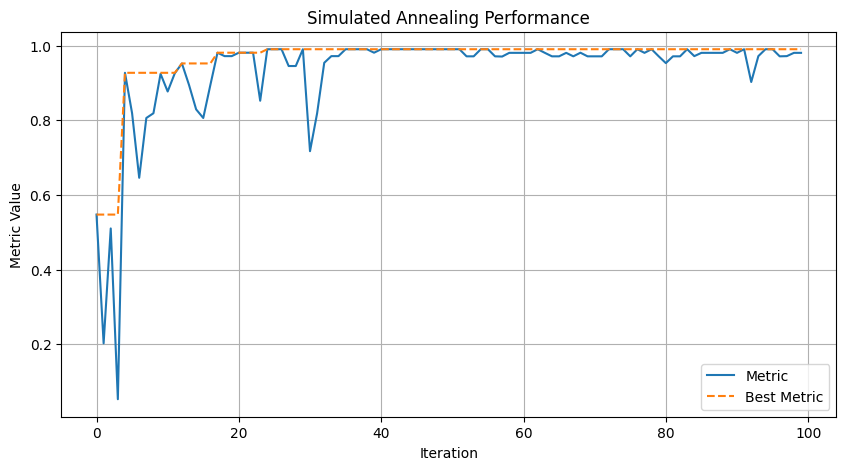

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(res.index, res['Metric'], label='Metric')
plt.plot(res.index, res['Best Metric'], label='Best Metric', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Simulated Annealing Performance')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
res[res.Metric==res['Best Metric'].max()]

,max_depth,subsample,colsample_bytree,learning_rate,gamma,scale_pos_weight,Metric,Best Metric
24,10,0.8,0.8,0.05,0.2,40,0.990476,0.990476
25,10,0.8,0.8,0.05,0.15,40,0.990476,0.990476
26,10,0.8,0.8,0.05,0.15,30,0.990476,0.990476
29,5,0.7,0.8,0.01,0.15,30,0.990476,0.990476
35,15,0.7,0.7,0.05,0.15,30,0.990476,0.990476
36,15,0.6,0.7,0.05,0.15,30,0.990476,0.990476
37,15,0.6,0.7,0.05,0.1,30,0.990476,0.990476
38,20,0.6,0.7,0.05,0.1,30,0.990476,0.990476
40,20,0.5,0.7,0.1,0.1,30,0.990476,0.990476
41,20,0.5,0.7,0.2,0.1,30,0.990476,0.990476


In [37]:
result = pd.DataFrame(res[res.Metric==res['Best Metric'].max()])

In [38]:
result.to_csv('output.csv', index=False)

In [36]:
preds = best_model.predict(xtest)
f1_score(ytest, preds)

0.9661016949152542